# 1. Data quality

You will generate some data quality insights for two models we have worked in the past:

* *campaign response from transaction data*

**For the second model, please use the best Random Forest model you created in the
previous assignment. We don’t need the perfect model (meaning don’t spend more time on
fine-tuning it), as long as it does not overfit.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from IPython import display as show

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook', style='darkgrid', palette='brg', font='sans-serif', font_scale=1.5, color_codes=True)

### Import Annual Excel files, Pre-process and Extract X and y

In [2]:
annual_features = pd.read_csv('annual_features.csv')
annual_day_of_week_counts_pivot = pd.read_csv('annual_day_of_week_counts_pivot.csv')
Retail_Data_Response = pd.read_csv('Retail_Data_Response.csv')

In [3]:
annual_features_output = annual_features.merge(annual_day_of_week_counts_pivot, how = 'inner',
                                               left_on = 'customer_id',
                                               right_on = 'id_customer')
annual_features_output = annual_features_output.merge(Retail_Data_Response, how = 'inner',
                                                      on = 'customer_id')
annual_features_output = annual_features_output.drop(['customer_id', 'id_customer'], axis = 1)
annual_features_output = annual_features_output.fillna(0)

# annual_features_output

In [4]:
X = annual_features_output.drop(['response'], axis = 1)
y = annual_features_output['response']

### Explore the inputs X and y

In [5]:
# Exploring the X inputs
show.display(X.head(5))
print(X.shape)

# Exploring the y inputs
show.display(y.head(5))
print(y.shape)

,sum_amt_txn_ann_2011,mean_amt_txn_ann_2011,std_amt_txn_ann_2011,var_amt_txn_ann_2011,sem_amt_txn_ann_2011,max_amt_txn_ann_2011,min_amt_txn_ann_2011,count_amt_txn_ann_2011,sum_amt_txn_ann_2012,mean_amt_txn_ann_2012,...,Thursday_trans_count_2014,Friday_trans_count_2014,Saturday_trans_count_2014,Sunday_trans_count_2015,Monday_trans_count_2015,Wednesday_trans_count_2015,Tuesday_trans_count_2015,Thursday_trans_count_2015,Friday_trans_count_2015,Saturday_trans_count_2015
0,212,70.666667,22.030282,485.333333,12.719189,96,56,3,337,67.400000,...,1,0,0,0,0,0,1,0,0,0
1,244,81.333333,21.079216,444.333333,12.170091,94,57,3,374,74.800000,...,0,0,1,0,2,0,1,0,0,0
2,426,85.200000,9.731393,94.700000,4.352011,97,76,5,150,75.000000,...,0,1,1,0,0,0,0,1,0,0
3,261,87.000000,15.000000,225.000000,8.660254,102,72,3,473,67.571429,...,2,0,0,0,0,0,0,1,0,0
4,235,58.750000,21.203380,449.583333,10.601690,87,41,4,230,76.666667,...,0,3,0,0,0,0,0,0,0,0


(6884, 75)


0    0
1    0
2    1
3    1
4    1
Name: response, dtype: int64

(6884,)


### What is the percentage of non-zero elements in X

In [6]:
print("The percentage of non-zero elements in X is: {:.2f} %".format(np.count_nonzero(X) / X.size * 100))

The percentage of non-zero elements in X is: 63.68 %


### Explore the distribution of the output error we are predicting

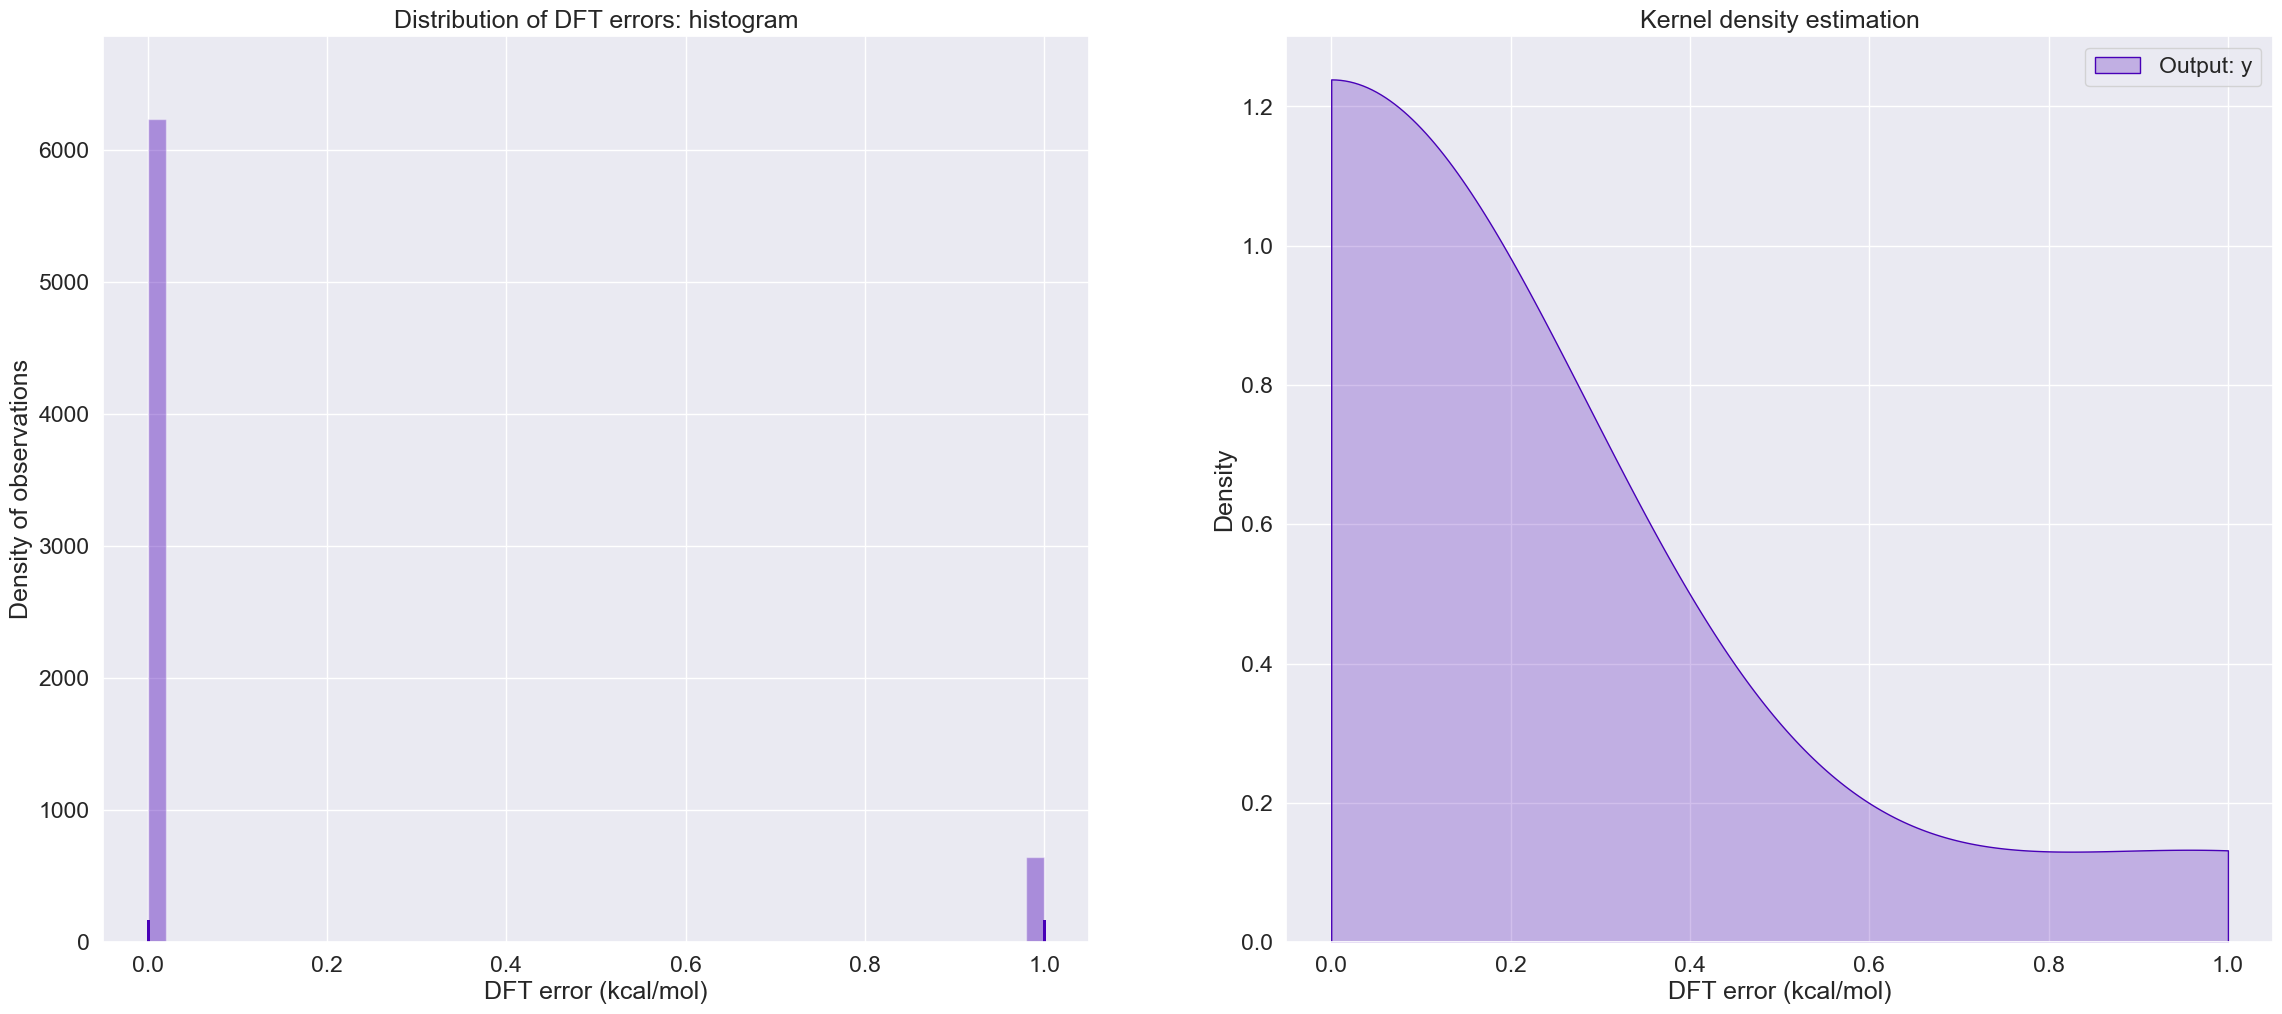

In [7]:
f, axes = plt.subplots(1, 2, figsize = (28, 12), dpi = 100)
# Left plot: Histogram
sns.distplot(y, kde = False, norm_hist = False, rug = True, label = "Output: y", ax = axes[0])
axes[0].set_title('Distribution of DFT errors: histogram')
axes[0].set_xlabel('DFT error (kcal/mol)')
axes[0].set_ylabel('Count of observations')

# Right plot: Kernel Density Estimation
sns.kdeplot(y, shade = True, clip = (y.min(),y.max()), bw_method = 1, label = "Output: y", ax = axes[1])
axes[1].set_title('Kernel density estimation')
axes[1].set_xlabel('DFT error (kcal/mol)')
axes[0].set_ylabel('Density of observations')
plt.legend()
plt.show()

### Split X and y in training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 2/3, random_state = 1147)
print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)
print('X_test shape =', X_test.shape)
print('y_test shape =', y_test.shape)

X_train shape = (2294, 75)
y_train shape = (2294,)
X_test shape = (4590, 75)
y_test shape = (4590,)


### What is the percentage of non-zero elements in X_train

In [9]:
print("The percentage of non-zero elements in X is: {:.2f} %".format(np.count_nonzero(X_train) / X_train.size * 100))

The percentage of non-zero elements in X is: 63.66 %


### Deriving the best Random Forest Model

In [10]:
# Best Random Forest Model 

rf = RandomForestClassifier(random_state=1148)
params = {'n_estimators':[10, 20, 30, 40, 50, 60, 100], 'max_features':["auto", "sqrt", "log2"], 'max_depth':[2,4,6,8,10]}

# Best Hyperparameters found using GridSearch CV

grid = GridSearchCV(rf, param_grid=params, scoring ='accuracy', cv=5)
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 40}

In [11]:
# Training the best Model and fitting

rf = RandomForestClassifier(n_estimators = 40, max_features = 'auto', max_depth = 8, random_state = 1147)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=40,
                       random_state=1147)

### Compute Completeness

In [12]:
completeness = []
for i in range(75):
    temp = np.count_nonzero(X_train.iloc[:,i] / len(X_train.iloc[:,i]) * 100)
    completeness.append(temp)
    
# show.display(completeness)

### Compute Feature Importance

In [13]:
# Compute Feature Importance from the model
importances = rf.feature_importances_

# Converting it into a more presentable form
feature_importance = pd.DataFrame(importances, index = X_train.columns, columns = ['Feature Importance'])
feature_importance = feature_importance.sort_values(by = ['Feature Importance'], ascending = False)
feature_importance.head(10)

,Feature Importance
sum_amt_txn_ann_2014,0.072818
sum_amt_txn_ann_2013,0.055514
count_amt_txn_ann_2014,0.038018
mean_amt_txn_ann_2014,0.032318
mean_amt_txn_ann_2013,0.030513
max_amt_txn_ann_2014,0.025347
sem_amt_txn_ann_2013,0.022901
mean_amt_txn_ann_2012,0.022389
sum_amt_txn_ann_2012,0.022154
var_amt_txn_ann_2014,0.022067


### Figure - Feature Importance v/s Completeness

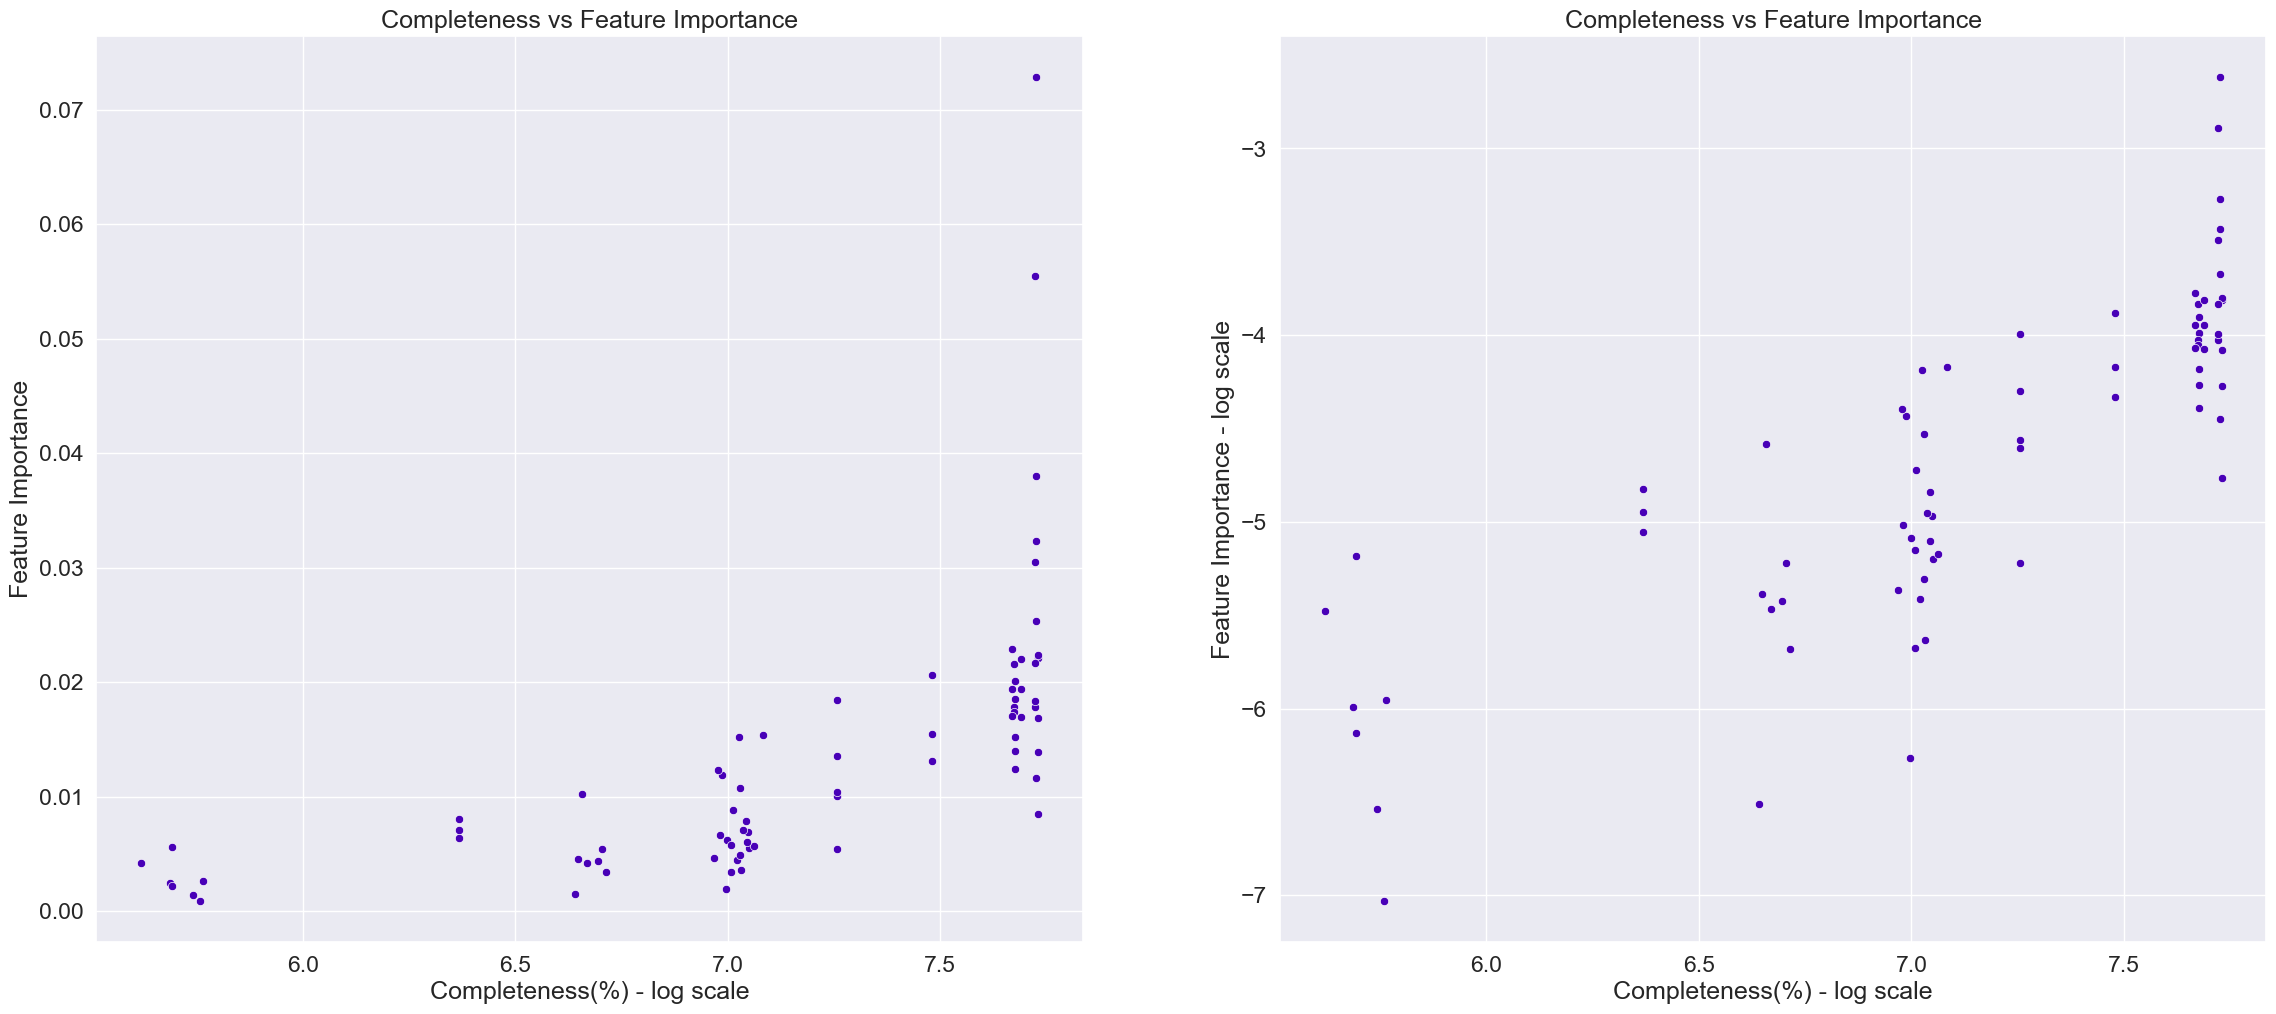

In [14]:
log_completeness = np.log(np.array(completeness))
log_feature_imp = np.log(np.array(importances))

f, axes = plt.subplots(1,2, figsize = (28,12), dpi = 100)

sns.scatterplot(log_completeness, importances, ax = axes[0])
axes[0].set_xlabel('Completeness(%) - log scale')
axes[0].set_ylabel('Feature Importance')
axes[0].set_title('Completeness vs Feature Importance')

sns.scatterplot(log_completeness, log_feature_imp, ax = axes[1])
axes[1].set_xlabel('Completeness(%) - log scale')
axes[1].set_ylabel('Feature Importance - log scale')
axes[1].set_title('Completeness vs Feature Importance')
plt.show()

#### Comment

From the graphs above, there seems to be `a strong correlation between the feature importance and the dataset completeness,` it's also observed from the log-log graph that after `completeness crosses 6.5, the points are more or less increasing in an upward direction between -6 to -3` also as the `completeness increases, feature importance also increases.`

A similar observation from the semi-log graph was seen, `as the dataset completeness increases, the importance of features increases`

Therefore I would `recommend and porbably implement the redesigning of the dataset with more features with higher completeness, rather than there being missing values in the data.` Also would recommend collection of more data of features that are mostly important rather and tring to keep that collection complete.